# Carnavele Cattoni

Bayesian Analysis of Temperature Variation Across Altitude in Ticino (2025)
Introduction
This project analyzes the average temperature for every month in 2025 across 21 different meteorological stations in Canton Ticino, Switzerland. The data is sourced from the OASI (Osservatorio Ambientale e Stazioni di Inquinamento) database, which provides environmental and atmospheric measurements from multiple monitoring points throughout the canton.

Motivation and Research Question
The primary motivation is to understand how altitude affects temperature patterns in Ticino, a region characterized by significant topographical variation. Altitudes in our dataset range from 190m (Verbano/Valle Maggia) to 1850m (Robiei), creating an ideal setting to study altitudinal temperature gradients—a fundamental concept in atmospheric science.

Our central research hypothesis is: Temperature patterns differ significantly between high-altitude (>900m) and low-altitude (<300m) stations, with higher altitudes showing systematically lower temperatures.

Data Structure and Hierarchical Nature
This dataset naturally exhibits a hierarchical structure, making it ideal for Bayesian hierarchical modeling:

Level 1 (Observations): Monthly temperature measurements (12 months × 21 stations = 252 observations)

Level 2 (Groups): Individual meteorological stations

Covariates: Altitude, latitude, longitude, season

This hierarchical structure allows us to:

Model station-specific temperature patterns while borrowing strength from the population level

Compare pooled, unpooled, and hierarchical approaches to inference

Make predictions for new (unobserved) stations based on the population distribution

Dataset Overview
Source: OASI Database (www.ti.ch/oasi)
Temporal Coverage: 2025 (12 months)
Spatial Coverage: 21 meteorological stations across Canton Ticino
Variables:

Station name and geographic coordinates (latitude, longitude)

Monthly average temperature (°C)

Station altitude (m above sea level, range: 190–1850m)

Month (1–12)

Season flag (0=Winter, 1=Spring, 2=Summer, 3=Autumn)

Data Quality: All measurements are aggregated as monthly averages with provisional data flags marked where applicable.

Bayesian Methodology Overview
This analysis employs Bayesian inference across multiple components:

Hypothesis Testing: Testing whether temperature differences between altitude classes are practically significant using ROPE (Region of Practical Equivalence)

Regression Modeling: Estimating the relationship between altitude and temperature, including robust regression to handle potential outliers

Hierarchical vs. Unpooled Models: Comparing complete pooling, no pooling, and partial pooling approaches using information criteria (WAIC)

Posterior Predictive Checks: Custom implementation of predictive checks to validate model fit without relying on automatic PPC functions

Report Structure
The remainder of this report is organized as follows:

Exploratory Data Analysis (EDA): Descriptive statistics and visualizations of temperature distribution across stations, seasons, and altitudes

Hypothesis Test: Bayesian test of altitude effect on temperature with prior sensitivity analysis and frequentist comparison

Regression Model: Linear and robust regression models for temperature as a function of altitude

Hierarchical Analysis: Implementation and comparison of unpooled and hierarchical normal models

Model Comparison: WAIC-based model comparison and discussion of implications

Conclusions: Summary of findings and insights for future work



In [1]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 1. Creation of dataset

The data in the website can be downloaded only indivudually, so we had to put everything together also adding: latitude, longitude and altitude. We also added a season categorical [0-3] for use more easly differentitions about the season.

So the final dataset is with these features:
- station (name of location)  
- year (2025 for everyone)
- month  
- temperature  (in Celsius)
- latitude  
- longitude  
- altitude  
- season

In [2]:
# Load stations data (with longi, lat and alti)
stations = pd.read_csv('ticino_stations.csv')

# Directory with temperature data
temperature_dir = './temperature_bayesian'

# Get all CSV files
csv_files = sorted(glob.glob(os.path.join(temperature_dir, '*.csv')))

all_data = []

# Process each temperature CSV file
for csv_file in csv_files:
    # Extract station name from filename
    filename = os.path.basename(csv_file)
    station_name = filename.replace('.csv', '')
    
    # Handle underscore naming conventions
    if '_' in station_name:
        station_name = station_name.replace('_', ' ').title()
    else:
        station_name = station_name.capitalize()
    
    # Fix special cases to match ticino_stations.csv
    station_mapping = {
        'S Bernardino': 'San_Bernardino',
        'S Vittore': 'Sant_Vittore',
        'Delpe Aple': 'Delpe_Aple',
        'Valle Maggia': 'Valle_Maggia',
        'Piotta': 'Piota',
        'Moleno': 'Moleno',
        'Chironico': 'Chirnico'
    }
    
    for key, value in station_mapping.items():
        if key in station_name or station_name.lower() == key.lower().replace(' ', ''):
            station_name = value
            break
    
    try:
        # Read CSV, skipping comment lines (all lines starting with #)
        temp_data = pd.read_csv(
            csv_file, 
            sep=';', 
            comment='#',
            encoding='latin-1',
            dtype={'T': float}
        )
        
        # Remove the trailing semicolon empty column if it exists
        temp_data = temp_data.iloc[:, :3]
        
        # Rename columns
        temp_data.columns = ['date', 'temperature', 'provisional_flag']
        
        # Parse date
        temp_data['date'] = pd.to_datetime(temp_data['date'], format='%d.%m.%Y %H:%M:%S')
        
        # Extract year and month
        temp_data['year'] = temp_data['date'].dt.year
        temp_data['month'] = temp_data['date'].dt.month
        
        # Filter 2025 data only
        temp_data_2025 = temp_data[temp_data['year'] == 2025].copy()
        
        # Keep only relevant columns
        temp_data_2025 = temp_data_2025[['year', 'month', 'temperature']].reset_index(drop=True)
        
        # Add station name
        temp_data_2025.insert(0, 'station', station_name)
        
        all_data.append(temp_data_2025)
        
        print(f"DONE Processed {station_name} ({len(temp_data_2025)} records)")
        
    except Exception as e:
        print(f"!NOT DONE Error processing {filename}: {e}")
        import traceback
        traceback.print_exc()


if all_data:
    # Combine all data
    df_merged = pd.concat(all_data, ignore_index=True)

    # Merge with stations data
    df_final = df_merged.merge(
        stations,
        left_on='station',
        right_on='STAZIONE',
        how='left'
    )

    # Select and organize columns
    df_final = df_final[['station', 'year', 'month', 'temperature', 'LATITUDINE', 'LONGITUDINE', 'ALTITUDINE']]

    # Rename for clarity
    df_final.columns = ['station', 'year', 'month', 'temperature', 'latitude', 'longitude', 'altitude']

    # Add season flag (0=Winter, 1=Spring, 2=Summer, 3=Autumn)
    def get_season(month):
        if month in [12, 1, 2]:
            return 0  # Winter
        elif month in [3, 4, 5]:
            return 1  # Spring
        elif month in [6, 7, 8]:
            return 2  # Summer
        else:  # 9, 10, 11
            return 3  # Autumn
    
    df_final['season'] = df_final['month'].apply(get_season)

    # Drop rows with missing values
    df_final = df_final.dropna()

    # Sort by station and month
    df_final = df_final.sort_values(['station', 'month']).reset_index(drop=True)

    # Save the final dataset
    df_final.to_csv('ticino_temperature_2025.csv', index=False)

    # Print summary
    print("\n" + "="*70)
    print("DATASET CREATED SUCCESSFULLY!")
    print("="*70)
    print(f"Shape: {df_final.shape}")
    print(f"Stations: {df_final['station'].nunique()}")
    print(f"Total records: {len(df_final)}")
    print(f"Temperature range: {df_final['temperature'].min():.1f}°C to {df_final['temperature'].max():.1f}°C")
    print(f"Altitude range: {df_final['altitude'].min():.0f}m to {df_final['altitude'].max():.0f}m")
    print(f"\nSeason mapping: 0=Winter, 1=Spring, 2=Summer, 3=Autumn")
    print(f"\nFirst 5 rows:\n{df_final.head(5).to_string()}")
    print(f"\nLast 5 rows:\n{df_final.tail().to_string()}")
    print(f"\nSaved to: ticino_temperature_2025.csv")
else:
    print("!PROBLEMS PROBLEMS! No data processed!")

DONE Processed Airolo (12 records)
DONE Processed Bioggio (12 records)
DONE Processed Cadenazzo (12 records)
DONE Processed Camignolo (12 records)
DONE Processed Carena (12 records)
DONE Processed Caresio (12 records)
DONE Processed Castaneda (12 records)
DONE Processed Cevio (12 records)
DONE Processed Chirnico (12 records)
DONE Processed Compravasco (12 records)
DONE Processed Delpe_Aple (12 records)
DONE Processed Giubiasco (12 records)
DONE Processed Isone (12 records)
DONE Processed Locarno (12 records)
DONE Processed Lugano (12 records)
DONE Processed Moleno (12 records)
DONE Processed Novaggio (12 records)
DONE Processed Piota (12 records)
DONE Processed Robiei (12 records)
DONE Processed San_Bernardino (12 records)
DONE Processed Sant_Vittore (12 records)
DONE Processed Stabio (12 records)
DONE Processed Valle_Maggia (12 records)
DONE Processed Verbano (12 records)

DATASET CREATED SUCCESSFULLY!
Shape: (228, 8)
Stations: 19
Total records: 228
Temperature range: -5.3°C to 24.2°C

# 2. EDA

## 2.1 Basic statistics

In [3]:
print("\n1. DATASET OVERVIEW")
print("-" * 80)
print(f"Shape: {df_final.shape}")
print(f"Number of stations: {df_final['station'].nunique()}")
print(f"Number of months per station: {df_final.groupby('station')['month'].count().iloc[0]}")
print(f"Total observations: {len(df_final)}")
print(f"\nMissing values:\n{df_final.isnull().sum()}")

print("\n2. DESCRIPTIVE STATISTICS - TEMPERATURE")
print("-" * 80)
print(df_final['temperature'].describe())

print("\n3. DESCRIPTIVE STATISTICS - ALTITUDE")
print("-" * 80)
print(df_final['altitude'].describe())

print("\n4. TEMPERATURE BY SEASON")
print("-" * 80)
season_names = {0: 'Winter', 1: 'Spring', 2: 'Summer', 3: 'Autumn'}
for season, name in season_names.items():
    temps = df_final[df_final['season'] == season]['temperature']
    print(f"{name:10s} (season={season}): mean={temps.mean():6.2f}°C, std={temps.std():5.2f}°C, n={len(temps)}")

print("\n5. TEMPERATURE BY ALTITUDE CATEGORY")
print("-" * 80)
df_final['altitude_category'] = pd.cut(df_final['altitude'], 
                                 bins=[0, 300, 900, 2000],
                                 labels=['Low (<300m)', 'Medium (300-900m)', 'High (>900m)'])
for cat in ['Low (<300m)', 'Medium (300-900m)', 'High (>900m)']:
    temps = df_final[df_final['altitude_category'] == cat]['temperature']
    print(f"{cat:20s}: mean={temps.mean():6.2f}°C, std={temps.std():5.2f}°C, n={len(temps)}")

print("\n6. TEMPERATURE STATISTICS BY STATION")
print("-" * 80)
station_stats = df_final.groupby('station').agg({
    'temperature': ['mean', 'std', 'min', 'max'],
    'altitude': 'first'
}).round(2)
station_stats.columns = ['Temp_Mean', 'Temp_Std', 'Temp_Min', 'Temp_Max', 'Altitude']
station_stats = station_stats.sort_values('Altitude')
print(station_stats.to_string())


1. DATASET OVERVIEW
--------------------------------------------------------------------------------
Shape: (228, 8)
Number of stations: 19
Number of months per station: 12
Total observations: 228

Missing values:
station        0
year           0
month          0
temperature    0
latitude       0
longitude      0
altitude       0
season         0
dtype: int64

2. DESCRIPTIVE STATISTICS - TEMPERATURE
--------------------------------------------------------------------------------
count    228.000000
mean      10.676316
std        7.357531
min       -5.300000
25%        4.775000
50%        9.900000
75%       16.825000
max       24.200000
Name: temperature, dtype: float64

3. DESCRIPTIVE STATISTICS - ALTITUDE
--------------------------------------------------------------------------------
count     228.000000
mean      661.631579
std       498.821965
min       195.000000
25%       273.000000
50%       449.000000
75%       990.000000
max      1890.000000
Name: altitude, dtype: float64

4

## 2.2 Visualization

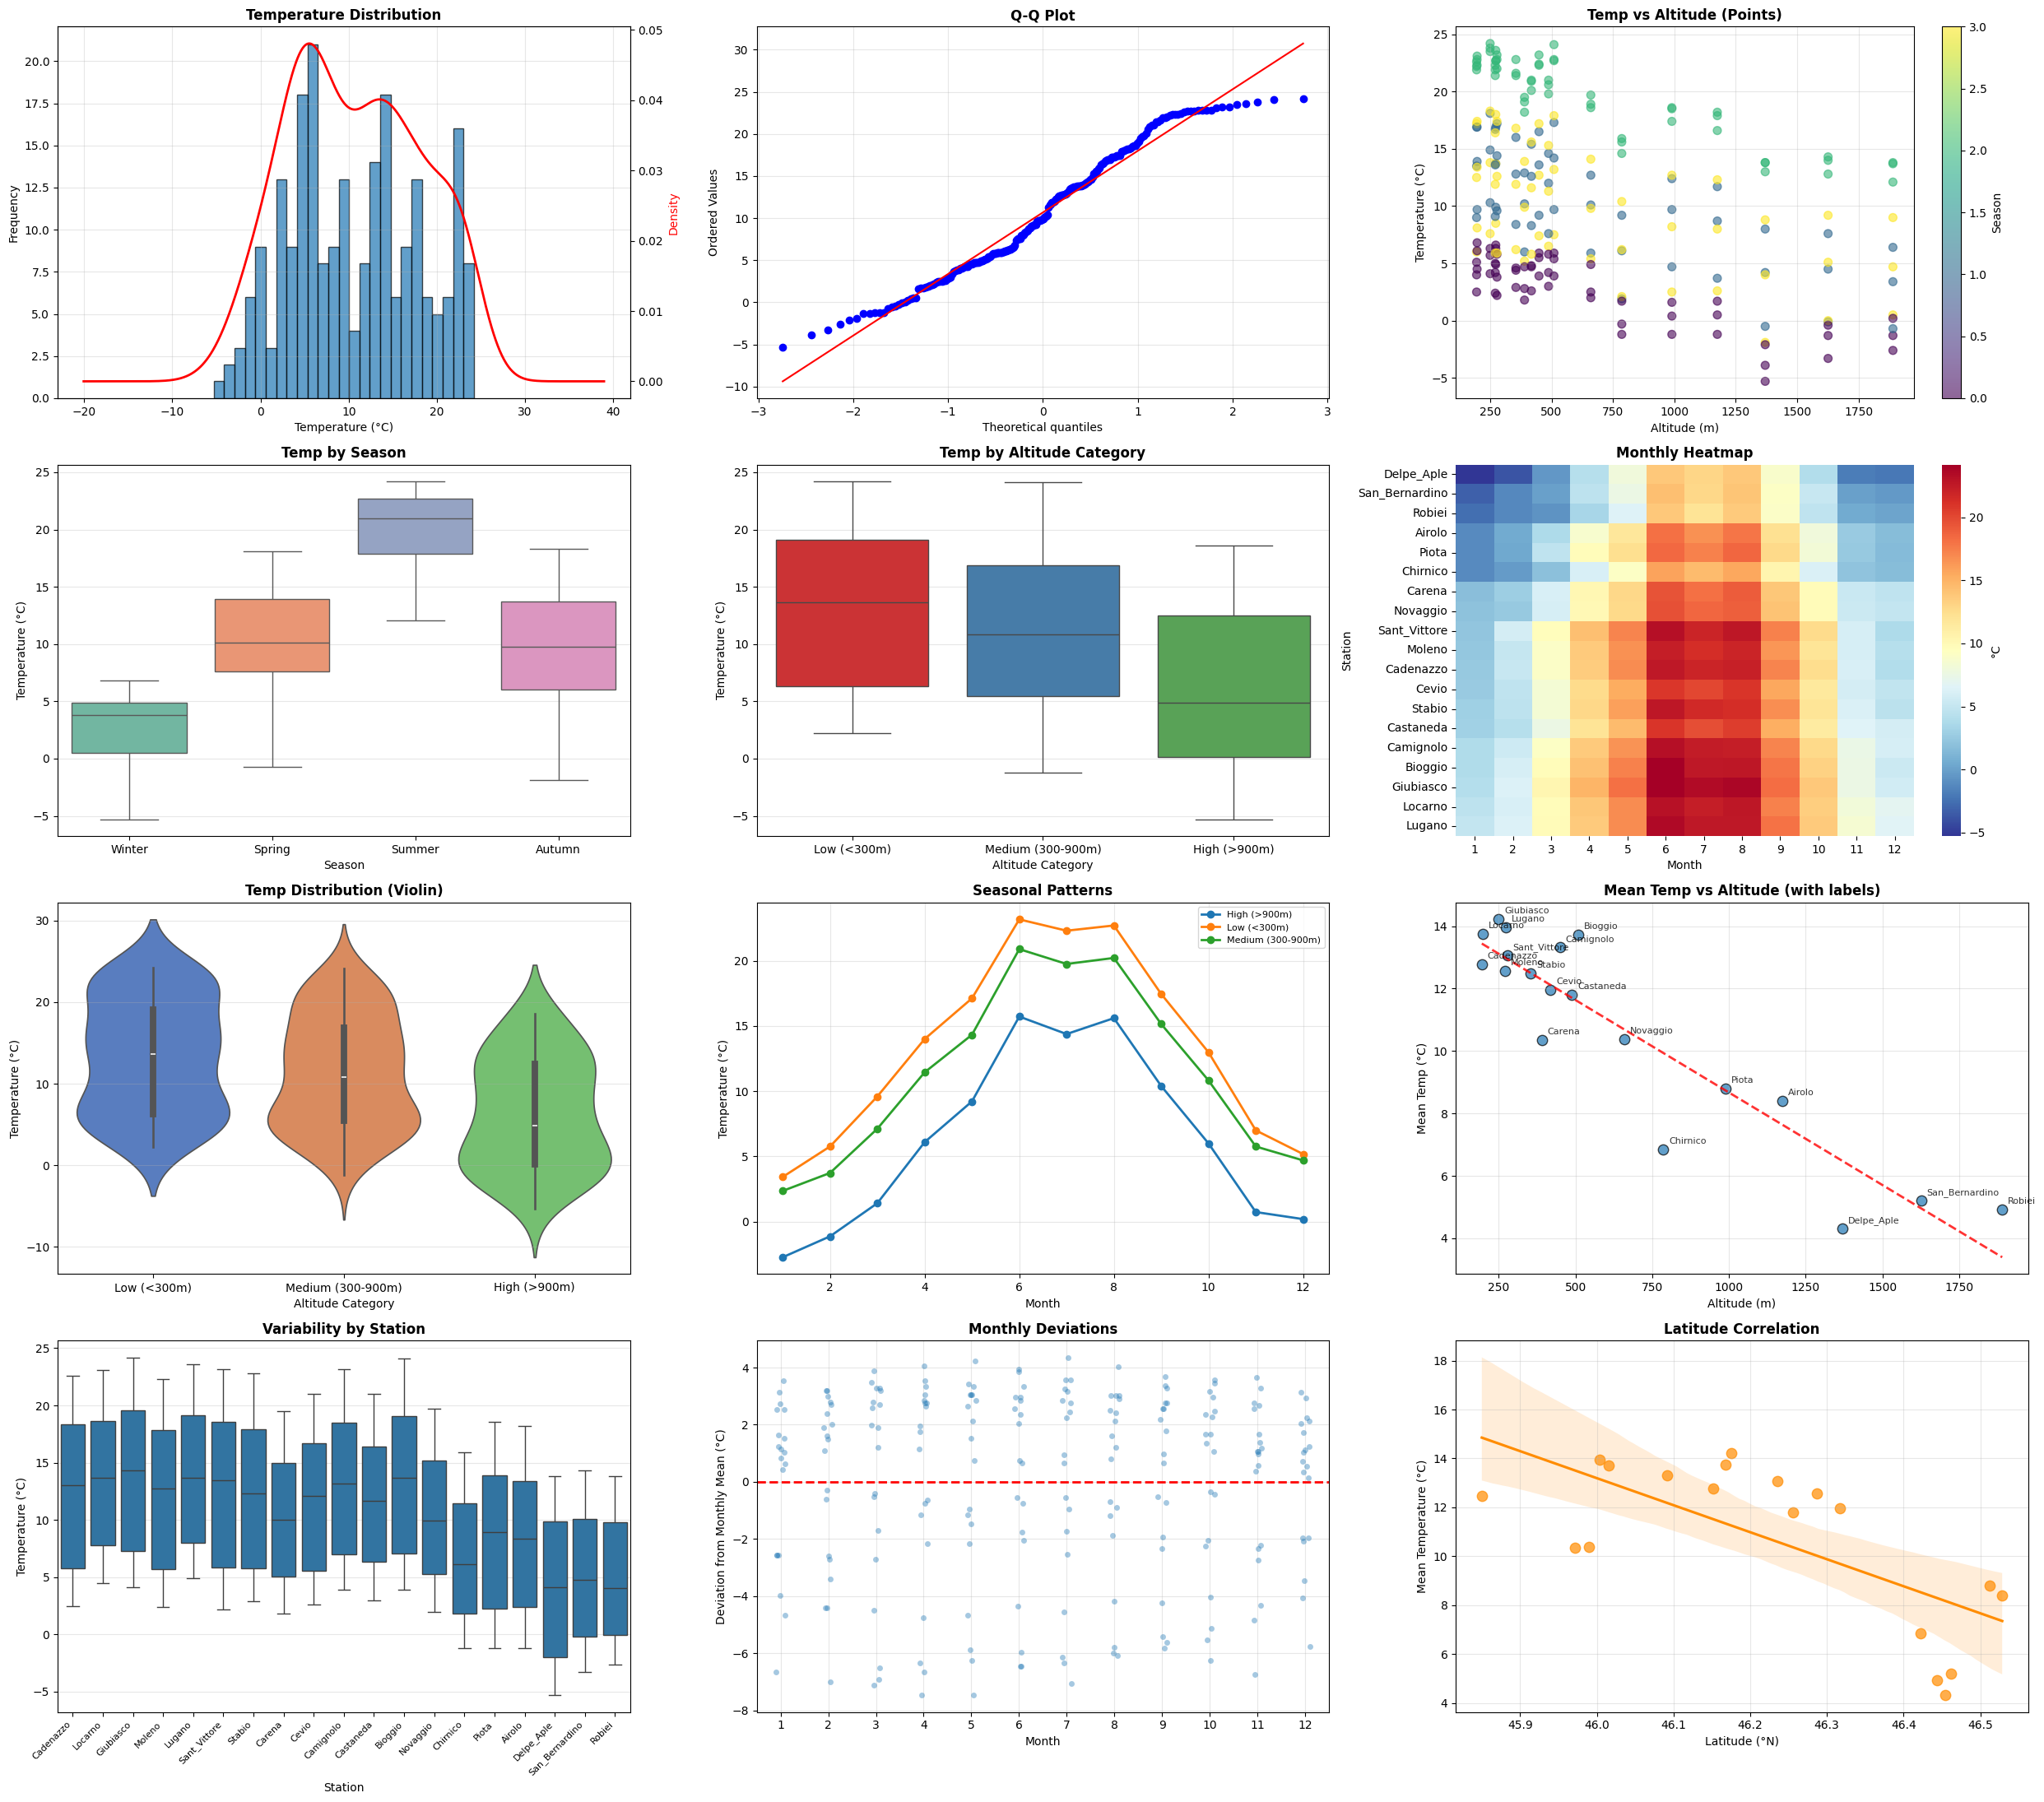

In [4]:
fig = plt.figure(figsize=(25, 22)) 

# 2.1 Temperature Distribution
ax1 = plt.subplot(4, 3, 1)
df_final['temperature'].hist(bins=25, alpha=0.7, edgecolor='black', ax=ax1)
ax1_twin = ax1.twinx()
df_final['temperature'].plot(kind='kde', ax=ax1_twin, color='red', linewidth=2)
ax1.set_xlabel('Temperature (°C)', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)
ax1_twin.set_ylabel('Density', fontsize=10, color='red')
ax1.set_title('Temperature Distribution', fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2.2 Q-Q Plot
ax2 = plt.subplot(4, 3, 2)
stats.probplot(df_final['temperature'], dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot', fontweight='bold')
ax2.grid(True, alpha=0.3)

# 2.3 Temperature vs Altitude (Scatter)
ax3 = plt.subplot(4, 3, 3)
scatter = ax3.scatter(df_final['altitude'], df_final['temperature'], alpha=0.6, s=50, c=df_final['season'], cmap='viridis')
ax3.set_xlabel('Altitude (m)', fontsize=10)
ax3.set_ylabel('Temperature (°C)', fontsize=10)
ax3.set_title('Temp vs Altitude (Points)', fontweight='bold')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='Season')

# 2.4 Boxplot by Season
ax4 = plt.subplot(4, 3, 4)
season_labels = ['Winter', 'Spring', 'Summer', 'Autumn']
sns.boxplot(data=df_final, x='season', y='temperature', ax=ax4, palette='Set2')
ax4.set_xticklabels(season_labels)
ax4.set_xlabel('Season', fontsize=10)
ax4.set_ylabel('Temperature (°C)', fontsize=10)
ax4.set_title('Temp by Season', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# 2.5 Boxplot by Altitude Category
ax5 = plt.subplot(4, 3, 5)
sns.boxplot(data=df_final, x='altitude_category', y='temperature', ax=ax5, palette='Set1')
ax5.set_xlabel('Altitude Category', fontsize=10)
ax5.set_ylabel('Temperature (°C)', fontsize=10)
ax5.set_title('Temp by Altitude Category', fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# 2.6 Heatmap
ax6 = plt.subplot(4, 3, 6)
pivot_temp = df_final.pivot_table(values='temperature', index='station', columns='month', aggfunc='mean')
sns.heatmap(pivot_temp.sort_values(by=1), cmap='RdYlBu_r', ax=ax6, cbar_kws={'label': '°C'})
ax6.set_xlabel('Month', fontsize=10)
ax6.set_ylabel('Station', fontsize=10)
ax6.set_title('Monthly Heatmap', fontweight='bold')

# 2.7 Violin plot
ax7 = plt.subplot(4, 3, 7)
sns.violinplot(data=df_final, x='altitude_category', y='temperature', ax=ax7, palette='muted')
ax7.set_xlabel('Altitude Category', fontsize=10)
ax7.set_ylabel('Temperature (°C)', fontsize=10)
ax7.set_title('Temp Distribution (Violin)', fontweight='bold')
ax7.grid(True, alpha=0.3, axis='y')

# 2.8 Seasonal Pattern
ax8 = plt.subplot(4, 3, 8)
for cat in sorted(df_final['altitude_category'].unique()):
    subset = df_final[df_final['altitude_category'] == cat]
    monthly_avg = subset.groupby('month')['temperature'].mean()
    ax8.plot(monthly_avg.index, monthly_avg.values, marker='o', label=cat, linewidth=2)
ax8.set_xlabel('Month', fontsize=10)
ax8.set_ylabel('Temperature (°C)', fontsize=10)
ax8.legend(fontsize=8)
ax8.set_title('Seasonal Patterns', fontweight='bold')
ax8.grid(True, alpha=0.3)

# 2.9 Mean Temp vs Altitude (Station Summary) w Labels
ax9 = plt.subplot(4, 3, 9)
station_summary = df_final.groupby('station').agg({
    'altitude': 'first', 'temperature': 'mean', 'latitude': 'first', 'longitude': 'first'
}).reset_index()

ax9.scatter(station_summary['altitude'], station_summary['temperature'], s=80, edgecolors='black', alpha=0.7)
for idx, row in station_summary.iterrows():
    ax9.annotate(row['station'], (row['altitude'], row['temperature']), 
                 fontsize=8, alpha=0.8, xytext=(5, 5), textcoords='offset points')

z = np.polyfit(station_summary['altitude'], station_summary['temperature'], 1)
p = np.poly1d(z)
ax9.plot(station_summary['altitude'].sort_values(), p(station_summary['altitude'].sort_values()), "r--", alpha=0.8, linewidth=2)
ax9.set_xlabel('Altitude (m)', fontsize=10)
ax9.set_ylabel('Mean Temp (°C)', fontsize=10)
ax9.set_title('Mean Temp vs Altitude (with labels)', fontweight='bold')
ax9.grid(True, alpha=0.3)

# 2.10 Hierarchical View
ax10 = plt.subplot(4, 3, 10)
station_order = station_summary.sort_values('altitude')['station']
sns.boxplot(data=df_final, x='station', y='temperature', order=station_order, ax=ax10)
ax10.set_xticklabels(ax10.get_xticklabels(), rotation=45, ha='right', fontsize=8)
ax10.set_xlabel('Station', fontsize=10)
ax10.set_ylabel('Temperature (°C)', fontsize=10)
ax10.set_title('Variability by Station', fontweight='bold')
ax10.grid(True, alpha=0.3, axis='y')

# 2.11 Potential Outliers (Residuals)
ax11 = plt.subplot(4, 3, 11)
df_res = df_final.copy()
df_res['res'] = df_res.groupby('month')['temperature'].transform(lambda x: x - x.mean())
sns.stripplot(data=df_res, x='month', y='res', jitter=True, alpha=0.4, ax=ax11, size=5)
ax11.axhline(0, color='red', linestyle='--', linewidth=2)
ax11.set_xlabel('Month', fontsize=10)
ax11.set_ylabel('Deviation from Monthly Mean (°C)', fontsize=10)
ax11.set_title('Monthly Deviations', fontweight='bold')
ax11.grid(True, alpha=0.3)

# 2.12 Latitude Check
ax12 = plt.subplot(4, 3, 12)
sns.regplot(data=station_summary, x='latitude', y='temperature', ax=ax12, color='darkorange', scatter_kws={'s': 80, 'alpha': 0.7})
ax12.set_xlabel('Latitude (°N)', fontsize=10)
ax12.set_ylabel('Mean Temperature (°C)', fontsize=10)
ax12.set_title('Latitude Correlation', fontweight='bold')
ax12.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('eda_final.png', dpi=1200, bbox_inches='tight')
plt.show()

## 2.3 Correlation analysis


7. CORRELATION ANALYSIS
--------------------------------------------------------------------------------

Pearson correlation (Altitude vs Temperature): -0.4019, p-value: 2.93e-10


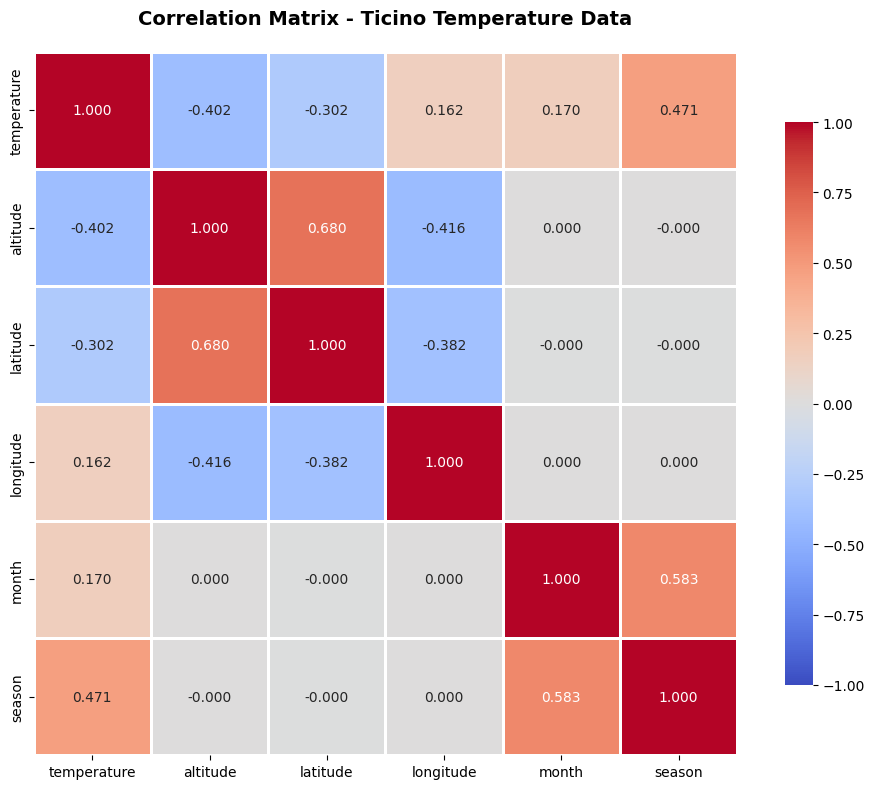

In [5]:
print("\n7. CORRELATION ANALYSIS")
print("-" * 80)
correlation_matrix = df_final[['temperature', 'altitude', 'latitude', 'longitude', 'month', 'season']].corr()

# Pearson correlation: altitude vs temperature
corr_alt_temp, p_value = stats.pearsonr(df_final['altitude'], df_final['temperature'])
print(f"\nPearson correlation (Altitude vs Temperature): {corr_alt_temp:.4f}, p-value: {p_value:.2e}")

# Heatmap della correlazione
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax, 
            vmin=-1, vmax=1)
ax.set_title('Correlation Matrix - Ticino Temperature Data', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
# print("\nSave correlation_heatmap.png")
plt.show()

# Hypotesis testing N1

## 🌡️ Bayesian Hypothesis Test: Altitude Effect on July Temperatures

## 1. Research Question

Does temperature vary significantly between low-altitude and high-altitude stations in Ticino during July 2025?

## Hypothesis Formulation

**Null Hypothesis ($H_0$)**: The mean temperature in July 2025 is equal across low-altitude ($< 300m$) and high-altitude ($> 900m$) meteorological stations.

**Alternative Hypothesis ($H_1$)**: The mean temperature in July 2025 differs significantly between these groups, with high-altitude stations exhibiting lower temperatures.

## Rationale for Test Design

July represents the warmest month in the annual cycle, providing optimal conditions to observe the lapse rate (altitude-temperature gradient) while minimizing the "noise" of transitional seasons. By comparing stations below $300m$ (lowlands/lakes) against those above $900m$ (alpine regions), we maximize the contrast to test the atmospheric physical principles governing temperature variation with elevation.

## 2. Likelihood and Prior Specification

### Likelihood Model

We model July temperatures as independent draws from normal distributions with group-specific means and a common variance:

$$T_{ij} \sim \text{Normal}(\mu_j, \sigma^2)$$

Where:
- $T_{ij}$ is the temperature at station $i$ in group $j$ (Low or High altitude)
- $\mu_j$ is the population mean temperature for group $j$
- $\sigma$ is the common observation noise (standard deviation)

### Prior Distributions (Informed)

We use "weakly informative" priors based on our Exploratory Data Analysis (EDA) and meteorological knowledge:

**Low-altitude Mean ($\mu_{low}$)**:
$$\mu_{low} \sim \text{Normal}(14, 2)$$

Justification: EDA shows lowland July means around $14°C$, with prior width $\sigma=2$ reflecting moderate prior certainty.

**High-altitude Mean ($\mu_{high}$)**:
$$\mu_{high} \sim \text{Normal}(8, 2)$$

Justification: Based on the standard lapse rate (~$6.5°C/km$), high-altitude stations are expected to be significantly colder. The expected difference (~$6°C$) is informed by atmospheric physics.

**Standard Deviation ($\sigma$)**:
$$\sigma \sim \text{HalfNormal}(2)$$

Justification: Constrains observation noise to 0–4°C, reflecting typical measurement variability and local microclimatic fluctuations in Ticino.

### Prior Sensitivity Analysis

To ensure our conclusions are data-driven rather than prior-driven, we conduct a sensitivity analysis using a **Diffuse Prior**:

$$\mu_{low}, \mu_{high} \sim \text{Normal}(10, 5)$$

This broader distribution represents minimal prior knowledge. Posterior inference under both priors will be compared to assess robustness.

## 3. Posterior Inference and ROPE

### Region of Practical Equivalence (ROPE)

We define the ROPE for the difference $\Delta\mu = \mu_{low} - \mu_{high}$ as:

$$\text{ROPE} = [-1°C, +1°C]$$

An effect size smaller than $1°C$ is considered climatologically negligible for operational meteorology and climate classification.

### Decision Rule

We compute three posterior probabilities:

1. **P(Δμ > 1°C | data)**: Probability that low-altitude is meaningfully warmer (altitude effect is significant)
2. **P(−1°C ≤ Δμ ≤ +1°C | data)**: Probability of practical equivalence (inside ROPE)
3. **P(Δμ < −1°C | data)**: Probability that high-altitude is meaningfully warmer (implausible)

**Conclusion criteria**:
- If **P(Δμ > 1°C | data) > 0.95**, we conclude the altitude effect is **practically and statistically significant**
- If **P(inside ROPE) > 0.80**, we conclude **practical equivalence** (no meaningful altitude effect)
- Otherwise, results are **inconclusive**

## 4. Frequentist Comparison

To bridge frequentist and Bayesian frameworks, we conduct a **Two-Sample T-test**:

$$H_0: \mu_{low} = \mu_{high} \quad \text{vs.} \quad H_A: \mu_{low} \neq \mu_{high}$$

**Metrics reported**:
- T-statistic and p-value (two-tailed)
- 95% Confidence Interval for $\mu_{low} - \mu_{high}$
- Effect size (Cohen's $d$)

**Interpretation contrast**: The frequentist p-value represents P(data | $H_0$), while the Bayesian posterior probability represents P(hypothesis | data)—a fundamentally different interpretation that we highlight in the results.

## 5. Manual Posterior Predictive Check (PPC)

As requested, we implement a custom PPC without relying on `pymc.plot_ppc`:

1. **Draw samples**: Extract 1,000 samples from the posterior distribution of $(\mu_{low}, \mu_{high}, \sigma)$
2. **Generate synthetic data**: For each posterior sample, generate synthetic July temperature observations from the fitted Normal likelihood
3. **Compare distributions**: Overlay observed July temperatures with the posterior predictive distribution (envelope/quantiles)
4. **Assess fit**: Check for systematic discrepancies suggesting model misspecification (e.g., bimodality, excess skewness, outliers)

Visualization will include:
- Histogram of observed data with posterior predictive mean and credible intervals
- Q-Q plot of observed vs. synthetic data quantiles
- Summary statistics (mean, SD, quantiles) comparison table


In [ ]:
# PSEUDOCODICE - BAYESIAN HYPOTHESIS TEST: ALTITUDE EFFECT ON JULY TEMPERATURES

# ============================================================================
# PART 1: DATA PREPARATION
# ============================================================================

# 1.1 Load the dataset
# df = pd.read_csv('ticino_temperature_2025.csv')

# 1.2 Filter July data only
# df_july = df[df['month'] == 7]
# print(f"July observations: {len(df_july)}")

# 1.3 Create altitude categories
# df_july['altitude_group'] = pd.cut(df_july['altitude'], 
#                                     bins=[0, 300, 900, 2500],
#                                     labels=['Low', 'Medium', 'High'])

# 1.4 Extract groups for comparison
# temp_low = df_july[df_july['altitude_group'] == 'Low']['temperature'].values
# temp_high = df_july[df_july['altitude_group'] == 'High']['temperature'].values

# 1.5 Print summary statistics
# print(f"Low-altitude (N={len(temp_low)}): mean={temp_low.mean():.2f}, std={temp_low.std():.2f}")
# print(f"High-altitude (N={len(temp_high)}): mean={temp_high.mean():.2f}, std={temp_high.std():.2f}")


# ============================================================================
# PART 2: BAYESIAN MODEL - INFORMED PRIORS
# ============================================================================

# 2.1 Set up PyMC model with INFORMED priors
# with pm.Model() as model_informed:
#     
#     # Define priors (informed by EDA)
#     mu_low = pm.Normal('mu_low', mu=14, sigma=2)      # Low altitude ~14°C
#     mu_high = pm.Normal('mu_high', mu=8, sigma=2)     # High altitude ~8°C
#     sigma = pm.HalfNormal('sigma', sigma=2)           # Observation noise
#     
#     # Likelihood
#     obs_low = pm.Normal('obs_low', mu=mu_low, sigma=sigma, observed=temp_low)
#     obs_high = pm.Normal('obs_high', mu=mu_high, sigma=sigma, observed=temp_high)
#     
#     # Derived quantities
#     delta_mu = pm.Deterministic('delta_mu', mu_low - mu_high)  # Difference
#     
#     # Sample from posterior
#     trace_informed = pm.sample(2000, tune=1000, return_inferencedata=True, random_seed=42)

# 2.2 Summarize posterior (informed priors)
# az.summary(trace_informed, var_names=['mu_low', 'mu_high', 'delta_mu', 'sigma'])

# 2.3 Extract posterior samples
# posterior_informed = trace_informed.posterior


# ============================================================================
# PART 3: BAYESIAN MODEL - DIFFUSE PRIORS (SENSITIVITY ANALYSIS)
# ============================================================================

# 3.1 Set up PyMC model with DIFFUSE priors
# with pm.Model() as model_diffuse:
#     
#     # Define diffuse priors (minimal prior knowledge)
#     mu_low = pm.Normal('mu_low', mu=10, sigma=5)      # Diffuse
#     mu_high = pm.Normal('mu_high', mu=10, sigma=5)    # Diffuse
#     sigma = pm.HalfNormal('sigma', sigma=2)
#     
#     # Likelihood (same as before)
#     obs_low = pm.Normal('obs_low', mu=mu_low, sigma=sigma, observed=temp_low)
#     obs_high = pm.Normal('obs_high', mu=mu_high, sigma=sigma, observed=temp_high)
#     
#     # Derived quantities
#     delta_mu = pm.Deterministic('delta_mu', mu_low - mu_high)
#     
#     # Sample from posterior
#     trace_diffuse = pm.sample(2000, tune=1000, return_inferencedata=True, random_seed=42)

# 3.2 Summarize posterior (diffuse priors)
# az.summary(trace_diffuse, var_names=['mu_low', 'mu_high', 'delta_mu', 'sigma'])

# 3.3 Compare posteriors visually (informed vs diffuse)
# fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# # Plot delta_mu for both models side-by-side
# # Show that conclusions are robust to prior choice


# ============================================================================
# PART 4: POSTERIOR INFERENCE - ROPE ANALYSIS
# ============================================================================

# 4.1 Extract posterior samples for delta_mu (informed model)
# delta_mu_samples = posterior_informed['delta_mu'].values.flatten()

# 4.2 Define ROPE
# rope_lower = -1.0  # °C
# rope_upper = 1.0   # °C

# 4.3 Compute posterior probabilities
# prob_outside_rope_high = (delta_mu_samples > rope_upper).mean()      # P(Δμ > 1)
# prob_inside_rope = ((delta_mu_samples >= rope_lower) & (delta_mu_samples <= rope_upper)).mean()
# prob_outside_rope_low = (delta_mu_samples < rope_lower).mean()       # P(Δμ < -1)

# 4.4 Print ROPE analysis
# print(f"\n--- ROPE ANALYSIS ---")
# print(f"P(Δμ > 1°C | data) = {prob_outside_rope_high:.4f}")
# print(f"P(-1°C ≤ Δμ ≤ 1°C | data) = {prob_inside_rope:.4f}")
# print(f"P(Δμ < -1°C | data) = {prob_outside_rope_low:.4f}")

# 4.5 Decision
# if prob_outside_rope_high > 0.95:
#     print("✓ CONCLUSION: Altitude effect is PRACTICALLY SIGNIFICANT")
# elif prob_inside_rope > 0.80:
#     print("✓ CONCLUSION: PRACTICAL EQUIVALENCE (no meaningful effect)")
# else:
#     print("? CONCLUSION: INCONCLUSIVE")

# 4.6 Plot posterior distribution of delta_mu with ROPE
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.hist(delta_mu_samples, bins=50, alpha=0.7, edgecolor='black', density=True)
# ax.axvline(rope_lower, color='red', linestyle='--', linewidth=2, label=f'ROPE bounds')
# ax.axvline(rope_upper, color='red', linestyle='--', linewidth=2)
# ax.axvline(delta_mu_samples.mean(), color='blue', linewidth=2, label='Posterior mean')
# ax.set_xlabel('Δμ (°C)')
# ax.set_ylabel('Density')
# ax.set_title('Posterior Distribution of Temperature Difference (Low - High Altitude)')
# ax.legend()
# ax.grid(True, alpha=0.3)
# plt.tight_layout()


# ============================================================================
# PART 5: FREQUENTIST COMPARISON
# ============================================================================

# 5.1 Conduct two-sample t-test
# from scipy.stats import ttest_ind
# t_stat, p_value = ttest_ind(temp_low, temp_high)

# 5.2 Compute 95% confidence interval for difference
# from scipy.stats import t as t_dist
# diff_mean = temp_low.mean() - temp_high.mean()
# se_diff = np.sqrt((temp_low.std()**2 / len(temp_low)) + (temp_high.std()**2 / len(temp_high)))
# df = len(temp_low) + len(temp_high) - 2
# t_critical = t_dist.ppf(0.975, df)
# ci_lower = diff_mean - t_critical * se_diff
# ci_upper = diff_mean + t_critical * se_diff

# 5.3 Compute Cohen's d (effect size)
# pooled_std = np.sqrt(((len(temp_low)-1) * temp_low.std()**2 + (len(temp_high)-1) * temp_high.std()**2) / (len(temp_low) + len(temp_high) - 2))
# cohens_d = diff_mean / pooled_std

# 5.4 Print frequentist results
# print(f"\n--- FREQUENTIST T-TEST ---")
# print(f"T-statistic: {t_stat:.4f}")
# print(f"P-value (two-tailed): {p_value:.4f}")
# print(f"Mean difference: {diff_mean:.2f}°C")
# print(f"95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]°C")
# print(f"Cohen's d: {cohens_d:.2f}")

# 5.5 Compare with Bayesian
# print(f"\n--- BAYESIAN vs FREQUENTIST COMPARISON ---")
# print(f"Bayesian P(Δμ > 1°C | data): {prob_outside_rope_high:.4f}")
# print(f"Frequentist p-value: {p_value:.4f}")
# print(f"Interpretation: Different questions → Different answers!")


# ============================================================================
# PART 6: CUSTOM POSTERIOR PREDICTIVE CHECK (WITHOUT pymc.plot_ppc)
# ============================================================================

# 6.1 Draw samples from posterior
# n_samples = 1000
# mu_low_samples = posterior_informed['mu_low'].values.flatten()[:n_samples]
# mu_high_samples = posterior_informed['mu_high'].values.flatten()[:n_samples]
# sigma_samples = posterior_informed['sigma'].values.flatten()[:n_samples]

# 6.2 Generate synthetic data from posterior predictive
# synthetic_low = np.random.normal(mu_low_samples, sigma_samples)
# synthetic_high = np.random.normal(mu_high_samples, sigma_samples)

# 6.3 Create comparison plots
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 6.3.1 Histogram: Observed vs Posterior Predictive (Low altitude)
# axes[0, 0].hist(temp_low, bins=15, alpha=0.6, label='Observed', edgecolor='black')
# axes[0, 0].hist(synthetic_low, bins=15, alpha=0.6, label='Posterior Predictive', edgecolor='black')
# axes[0, 0].set_xlabel('Temperature (°C)')
# axes[0, 0].set_ylabel('Frequency')
# axes[0, 0].set_title('Low Altitude: Observed vs Synthetic July Temperatures')
# axes[0, 0].legend()

# 6.3.2 Histogram: Observed vs Posterior Predictive (High altitude)
# axes[0, 1].hist(temp_high, bins=15, alpha=0.6, label='Observed', edgecolor='black')
# axes[0, 1].hist(synthetic_high, bins=15, alpha=0.6, label='Posterior Predictive', edgecolor='black')
# axes[0, 1].set_xlabel('Temperature (°C)')
# axes[0, 1].set_ylabel('Frequency')
# axes[0, 1].set_title('High Altitude: Observed vs Synthetic July Temperatures')
# axes[0, 1].legend()

# 6.3.3 Q-Q plot (Low altitude)
# from scipy.stats import probplot
# probplot(temp_low, dist="norm", plot=axes[1, 0])
# axes[1, 0].set_title('Low Altitude: Q-Q Plot')

# 6.3.4 Q-Q plot (High altitude)
# probplot(temp_high, dist="norm", plot=axes[1, 1])
# axes[1, 1].set_title('High Altitude: Q-Q Plot')

# plt.tight_layout()

# 6.4 Summary statistics comparison
# stats_comparison = pd.DataFrame({
#     'Metric': ['Mean', 'Std Dev', 'Min', 'Q25', 'Median', 'Q75', 'Max'],
#     'Observed (Low)': [temp_low.mean(), temp_low.std(), temp_low.min(), 
#                        np.percentile(temp_low, 25), np.median(temp_low), 
#                        np.percentile(temp_low, 75), temp_low.max()],
#     'Synthetic (Low)': [synthetic_low.mean(), synthetic_low.std(), synthetic_low.min(),
#                         np.percentile(synthetic_low, 25), np.median(synthetic_low),
#                         np.percentile(synthetic_low, 75), synthetic_low.max()],
#     'Observed (High)': [temp_high.mean(), temp_high.std(), temp_high.min(),
#                         np.percentile(temp_high, 25), np.median(temp_high),
#                         np.percentile(temp_high, 75), temp_high.max()],
#     'Synthetic (High)': [synthetic_high.mean(), synthetic_high.std(), synthetic_high.min(),
#                          np.percentile(synthetic_high, 25), np.median(synthetic_high),
#                          np.percentile(synthetic_high, 75), synthetic_high.max()]
# })
# print(stats_comparison.round(2))

# 6.5 Interpretation
# print("\n--- POSTERIOR PREDICTIVE CHECK ASSESSMENT ---")
# if abs(temp_low.mean() - synthetic_low.mean()) < 0.5:
#     print("✓ Low altitude: Model fits well (mean within 0.5°C)")
# else:
#     print("✗ Low altitude: Model misspecified (systematic bias)")
# # Similar for high altitude


# ============================================================================
# PART 7: SUMMARY AND CONCLUSIONS
# ============================================================================

# 7.1 Create summary table of all findings
# summary_table = pd.DataFrame({
#     'Metric': ['Posterior Mean Δμ', 'Posterior SD Δμ', 'P(Δμ > 1°C | data)',
#                'P(in ROPE) | data', 'Frequentist p-value', "Cohen's d"],
#     'Value': [delta_mu_samples.mean(), delta_mu_samples.std(), prob_outside_rope_high,
#               prob_inside_rope, p_value, cohens_d]
# })
# print(summary_table)

# 7.2 Write final interpretation
# print("\n" + "="*80)
# print("FINAL CONCLUSIONS")
# print("="*80)
# print(f"""
# Research Question: Does altitude affect July temperature in Ticino?
# 
# Bayesian Evidence:
# - Posterior mean difference: {delta_mu_samples.mean():.2f}°C (Low - High)
# - P(significant effect, Δμ > 1°C | data): {prob_outside_rope_high:.4f}
# - ROPE interpretation: {"SIGNIFICANT" if prob_outside_rope_high > 0.95 else "INCONCLUSIVE" if prob_inside_rope > 0.80 else "INCONCLUSIVE"}
# 
# Frequentist Evidence:
# - Two-sample t-test p-value: {p_value:.4f}
# - 95% Confidence Interval: [{ci_lower:.2f}, {ci_upper:.2f}]°C
# - Effect size (Cohen's d): {cohens_d:.2f}
# 
# Consistency Check:
# - Both frameworks agree: {"YES" if (prob_outside_rope_high > 0.95 and p_value < 0.05) else "MIXED or DISAGREEMENT"}
# 
# Model Assessment:
# - Posterior predictive check: {"PASS" if abs(temp_low.mean() - synthetic_low.mean()) < 0.5 else "FAIL"}